<a href="https://colab.research.google.com/github/matibag1714977/LabiagiProject/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Progetto-Scene Classification**

#Import vari

In [ ]:
import numpy as np      #to perform mathematical operations on arrays and matrices
import matplotlib.pyplot as plt  #to visualize images and plot graphs

#provides algoithms and tools for data analysis and modeling(classification,regression,clustering)
from sklearn.model_selection import train_test_split        
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#It provides a user-friendly interface for building and training deep learning models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import keras

# It provides various tools and functions for image and video processing, including image filtering, feature detection, and object tracking.
import cv2
import imghdr
import os

import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf





#Import dataset Prova

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

folder_id = '1pFM_HpOjh0qbAadk0-1Fz89mwLHrnQHB?usp=share_link'
data_path = '/content/gdrive/MyDrive/Dataset/input_data'


# mount the folder
drive.mount('/content/gdrive', force_remount=True)




Mounted at /content/gdrive
Mounted at /content/gdrive


#Dividere tramite Pytorch

In [4]:
import os
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# Definisci la trasformazione delle immagini
transform = transforms.Compose(
    [transforms.Resize((224, 224)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

input_path='/content/gdrive/MyDrive/Dataset/input_data'
# Trasforma il dataset
dataset = datasets.ImageFolder(input_path, transform=transform)

print(dataset)

# Definisci le proporzioni di training, validation e test set
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

b_size=5

# Calcola le lunghezze dei subset
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Dividi il dataset in training, validation e test set
train_data, test_data, val_data = data.random_split(dataset, [train_size, test_size, val_size])

train_loader=data.DataLoader(train_data,batch_size=b_size, shuffle=True, num_workers=2)
validation_loader=data.DataLoader(val_data,batch_size=b_size, shuffle=False,  num_workers=2)
test_loader=data.DataLoader(test_data,batch_size=b_size,shuffle=False, num_workers=2)

print(len(train_data))
print(len(val_data))
print(len(test_data))

classes = ('airport_terminal', 'beach', 'bridge', 'forest',
           'mountain', 'playground', 'river', 'skyscraper', 'street', 'temple')





Dataset ImageFolder
    Number of datapoints: 6660
    Root location: /content/gdrive/MyDrive/Dataset/input_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
5328
666
666


#stampa prova

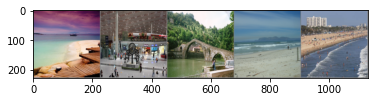

beach airport_terminal bridge beach beach


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(b_size)))

# Prova uso gpu

In [6]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("Using CPU")

Using GPU: Tesla T4


#Carico resnet50

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load ResNet50 model
resnet50 = models.resnet50(pretrained=False)




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#loss e optimizer

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [14]:

num_epochs=10

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 1:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
        print(i)
print('Finished Training')

0
[1,     2] loss: 0.066
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


KeyboardInterrupt: ignored

In [ ]:
# Valuta il modello sul dataset di test
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
accuracy = 100 * correct / total
print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))